# Data Cleaning

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder , OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_regression
import joblib
warnings.filterwarnings('ignore')


In [2]:
def cleaning(df:pd.DataFrame):
    df.columns = df.columns.str.strip().str.replace(" ", "_")

    df.drop_duplicates(inplace=True)

    df["Processor_Series"] = df["Processor_Series"].str.replace(" Gen1",".1").str.replace(" Gen2",".2").str.replace("Unknown","35").astype(float)

    # Clean 'memory_card_size' column: 1-Remove 'GB' and 'TB' text  2-Convert TB to GB  3-Convert the column to numerical type
    df["memory_card_size_GB"] = df["memory_card_size"].astype(str).str.replace("GB","").str.replace("TB","*1000").map(lambda X:eval(X)) # eval execute Python code
    df["memory_card_size_GB"] = df["memory_card_size_GB"].astype(int)
    df.drop(columns="memory_card_size",inplace=True)
    
    # Convert 'os_version' column to numerical:
    # Remove 'v' and dots
    df["os_version"] = df["os_version"].str.replace("v", "").str.replace(".", "", 1).astype(float)
    # Apply condition: if > 17, divide by 10 to correct the formatting
    df["os_version"] = df["os_version"].apply(lambda x: x / 10 if x > 17 else x)

    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    for c in categorical_columns:
      df[c] = df[c].str.lower().str.strip()
    
    return(df)

In [3]:
def replace_to_other(df,min_frq):
    # Group rare categories (below min_frq) as 'Other'
    for c in df:
        if df[c].dtype in ["object"]:
            count= df[c].value_counts()
            to_replace = count[count < min_frq].index
            df[c] = df[c].replace(to_replace, 'Other')
    
    return(df)


In [4]:
# Load the dataset
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

df_train= pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train = cleaning(df_train)
df_test = cleaning(df_test)

In [5]:
# Handle missing values in Train and Test sets

for c in df_train:
    # Fill numeric columns with the mean
    if df_train[c].dtype in ["int64", "float64"]:
        df_train[c].fillna(df_train[c].mean())

    # Fill categorical columns with the mode
    if df_train[c].dtype in ["object"]:
        df_train[c].fillna(df_train[c].mode()[0])
        df_train[c].str.replace("unknown", df_train[c].mode()[0])

for c in df_test:
    if df_test[c].dtype in ["int64", "float64"]:
        df_test[c].fillna(df_train[c].mean())

    if df_test[c].dtype in ["object"]:
        df_test[c].fillna(df_train[c].mode()[0])
        df_test[c].str.replace("unknown", df_train[c].mode()[0])




# Visualization 


In [6]:
numerical_features = ['rating', 'Core_Count', 'Clock_Speed_GHz', 
                      'RAM_Size_GB', 'Storage_Size_GB', 'battery_capacity', 
                      'fast_charging_power', 'Screen_Size', 'Resolution_Width', 'Resolution_Height', 
                      'Refresh_Rate', 'primary_rear_camera_mp', 'num_rear_cameras', 'primary_front_camera_mp', 'num_front_cameras']

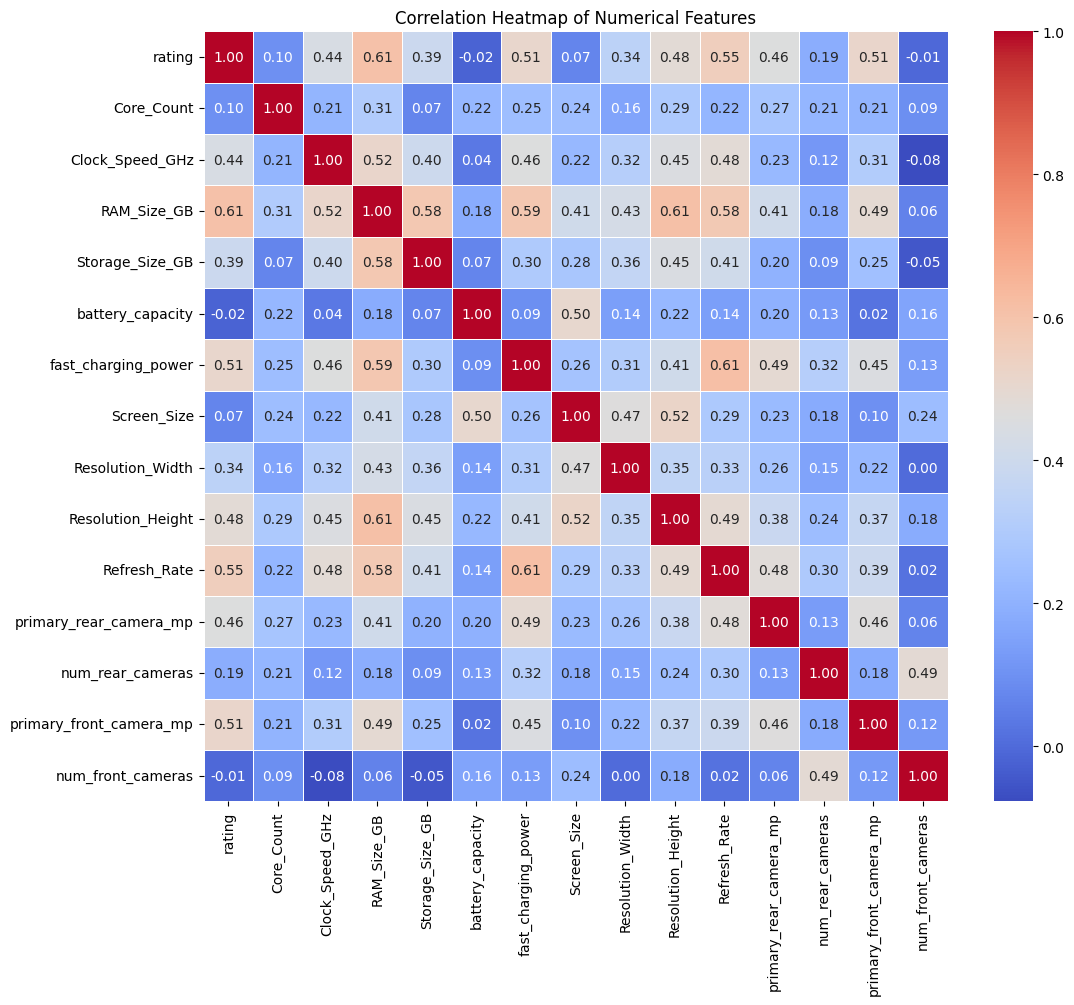

In [7]:
plt.figure(figsize=(12, 10))
corr = df_train[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# high positive correlations (RAM Size GB with Storage Size GB,RAM Size GB with rating)

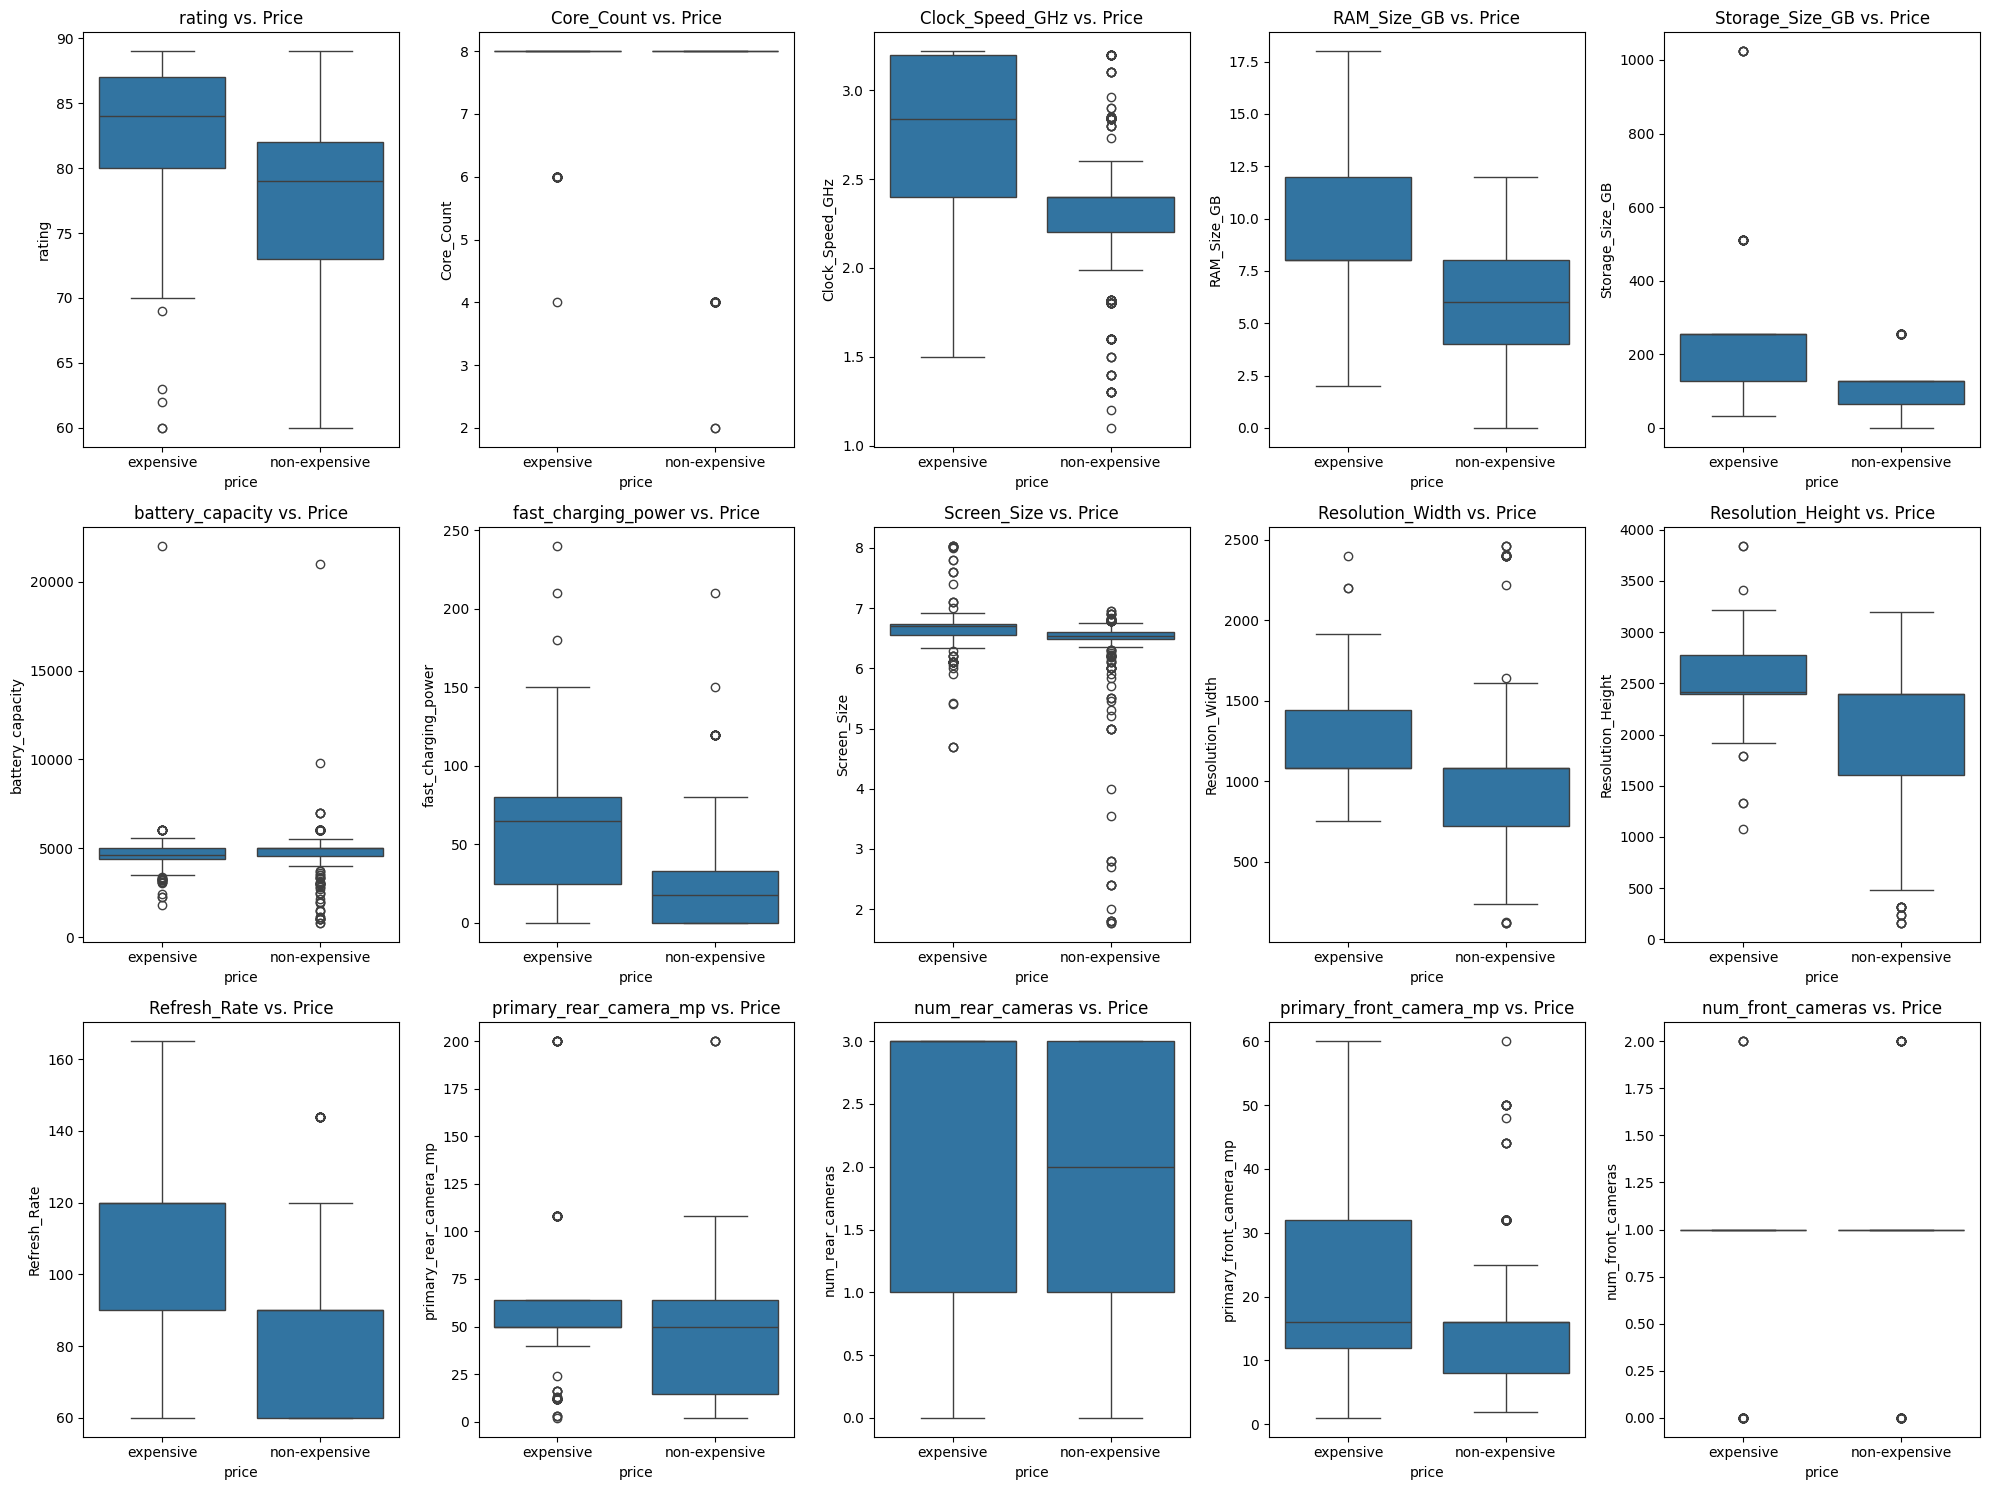

In [8]:
#Box Plots (Numerical Features vs. Price Category)

fig, axes = plt.subplots(3, 5, figsize=(20, 15))
numerical_features_subset = numerical_features[:15]  # Limit for readability

for i, feature in enumerate(numerical_features_subset):
    ax = axes[i//5, i%5]
    sns.boxplot(data=df_train, x='price', y=feature, ax=ax)
    ax.set_title(f'{feature} vs. Price')

plt.tight_layout()
plt.show()

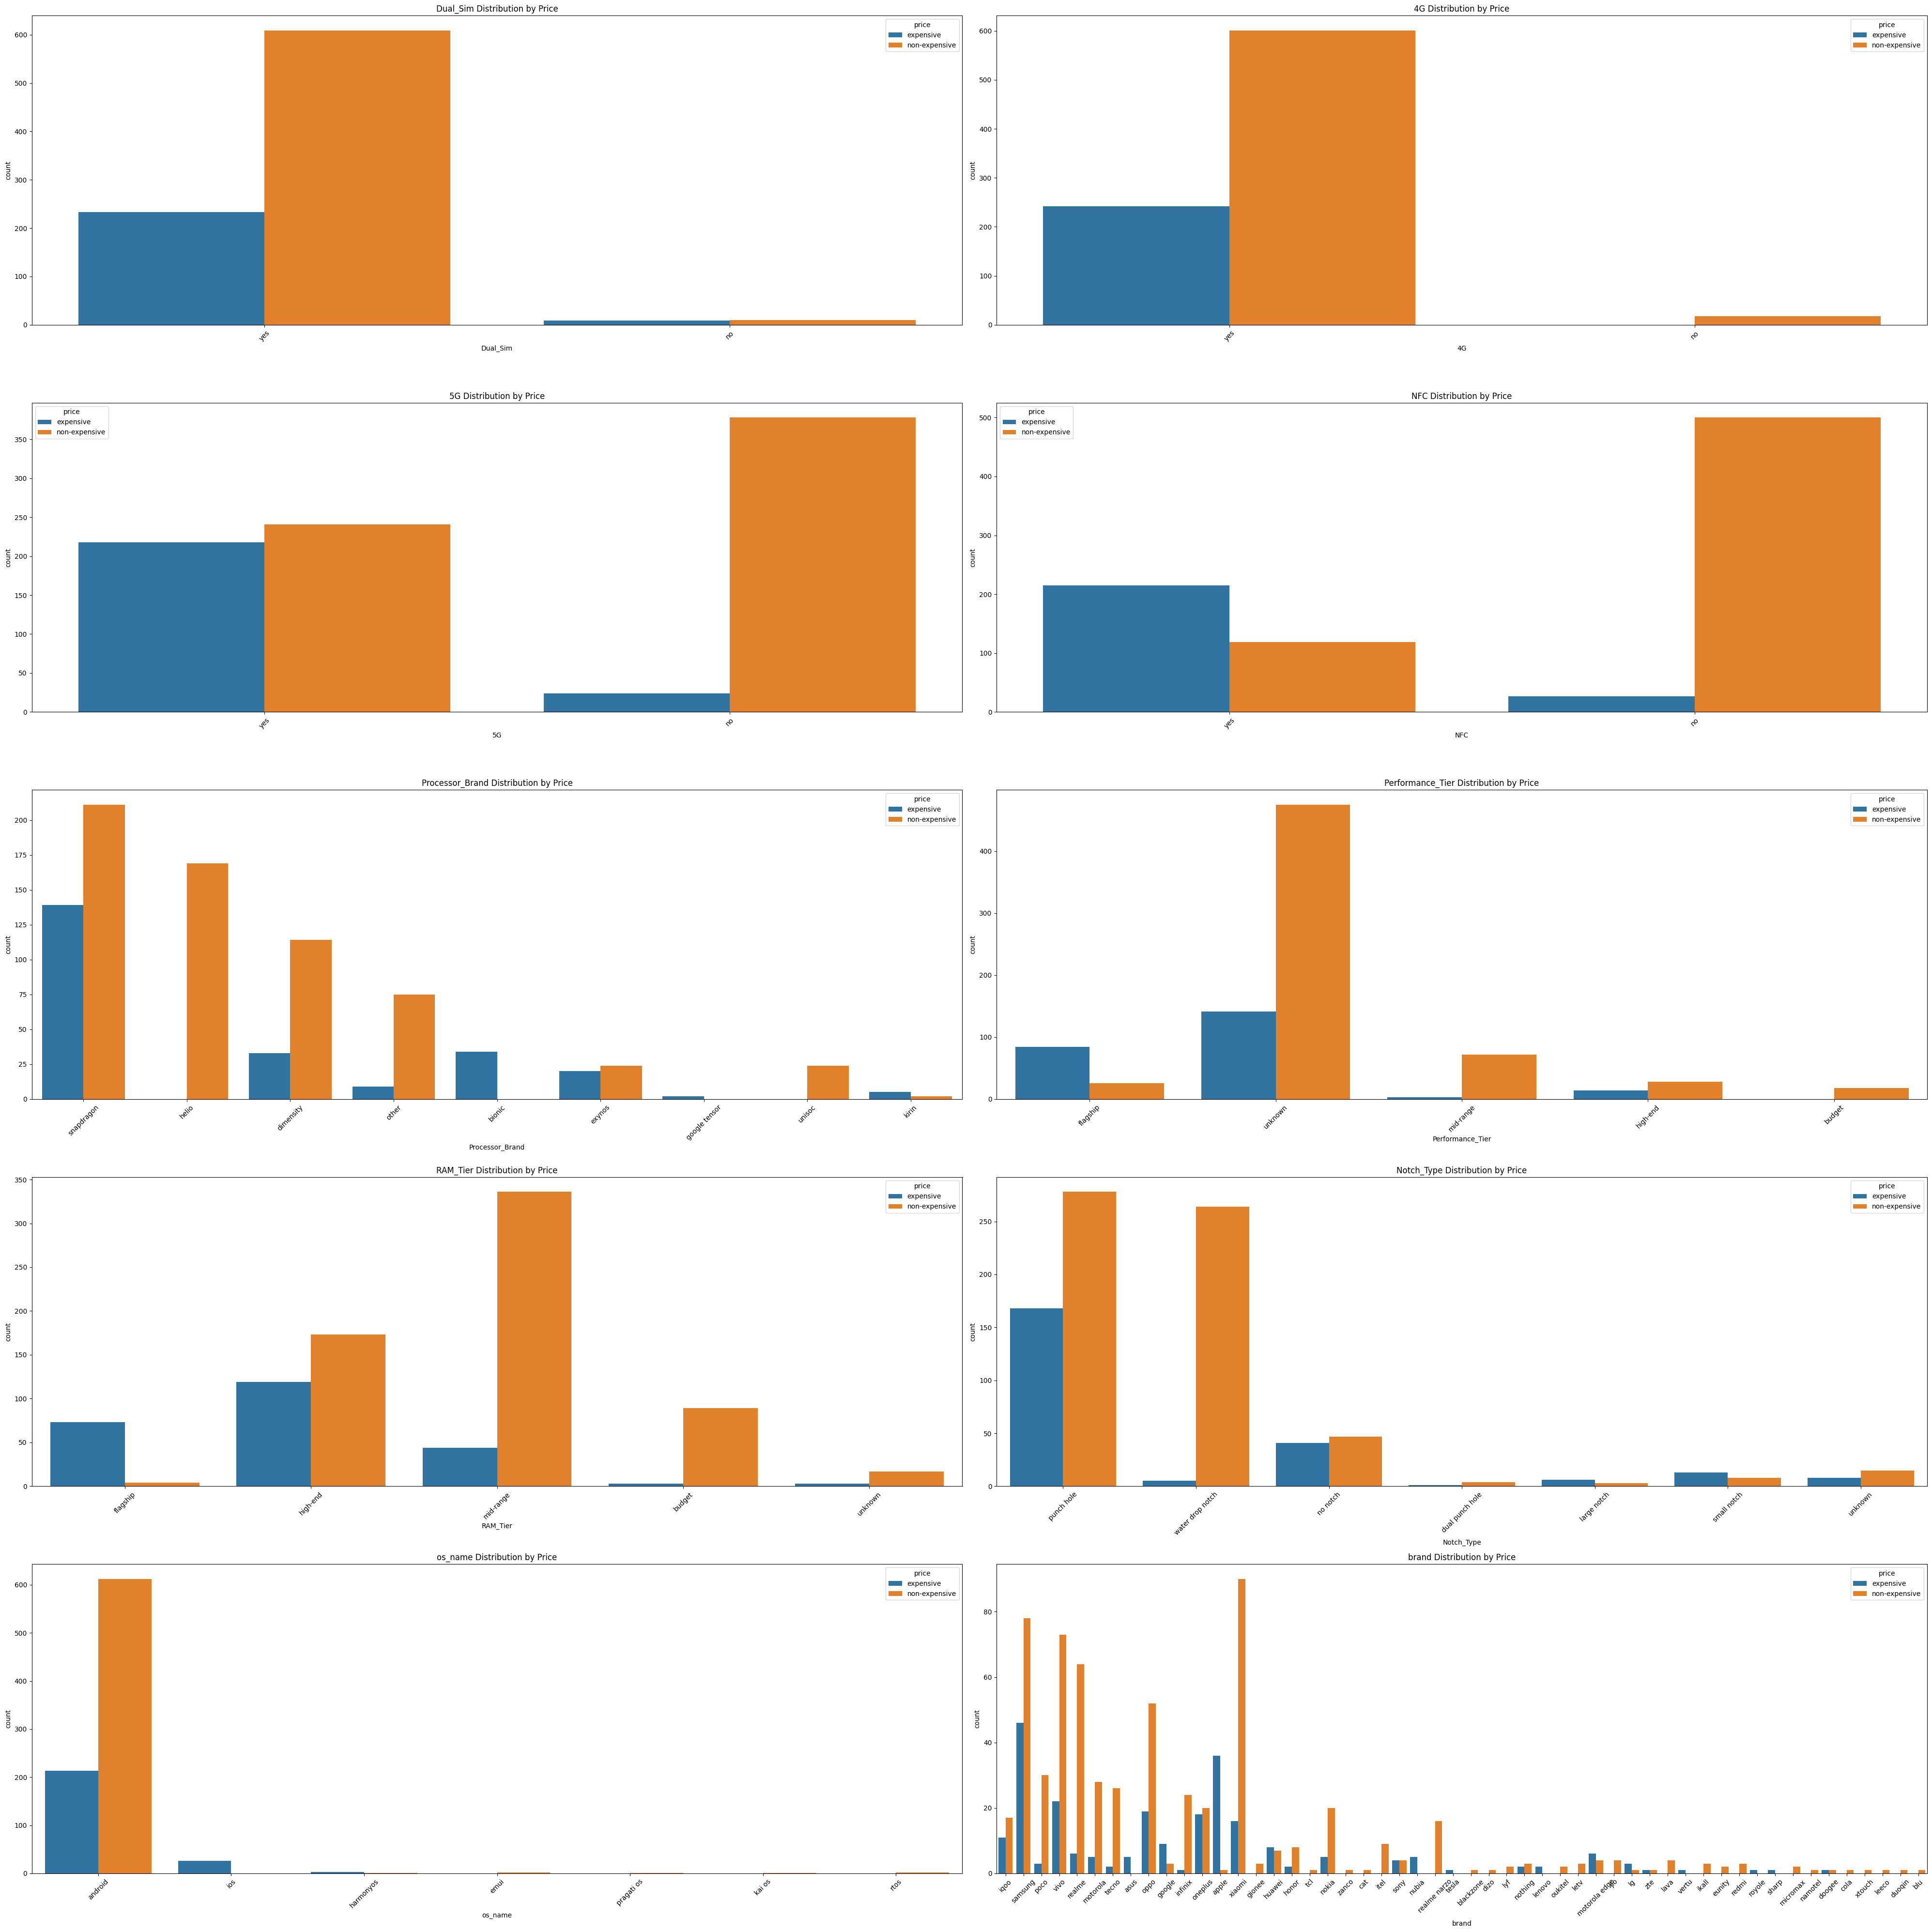

In [9]:
#Count Plots (Categorical Features vs. Price Category)

categorical_features = ['Dual_Sim', '4G', '5G', 'NFC', 'Processor_Brand', 'Performance_Tier', 'RAM_Tier', 'Notch_Type', 'os_name', 'brand']
fig, axes = plt.subplots(5, 2, figsize=(40, 40))

for i, feature in enumerate(categorical_features):
    ax = axes[i//2, i%2]
    sns.countplot(data=df_train, x=feature, hue='price', ax=ax)
    ax.set_title(f'{feature} Distribution by Price')
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

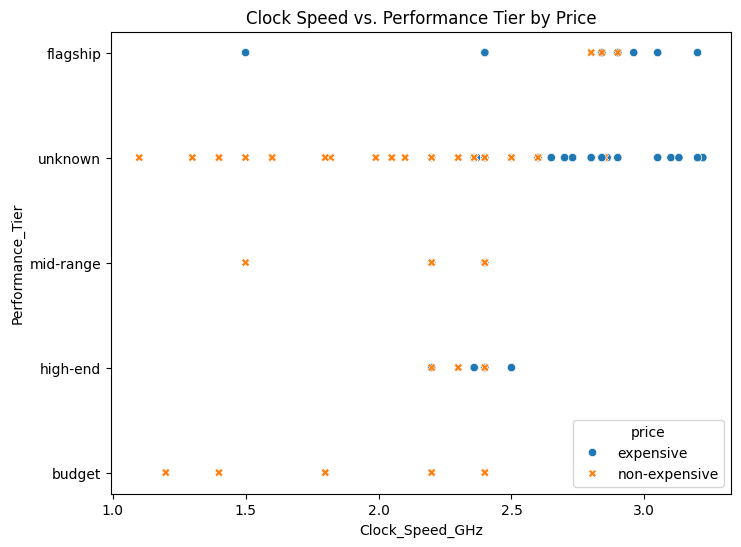

' Expensive price is concentrated at higher clock speeds (around 2.5–3.1 GHz) and\n     mostly in the High‑End and Flagship categories '

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_train, x='Clock_Speed_GHz', y='Performance_Tier', hue='price', style='price')
plt.title('Clock Speed vs. Performance Tier by Price')
plt.show()

""" Expensive price is concentrated at higher clock speeds (around 2.5–3.1 GHz) and
     mostly in the High‑End and Flagship categories """

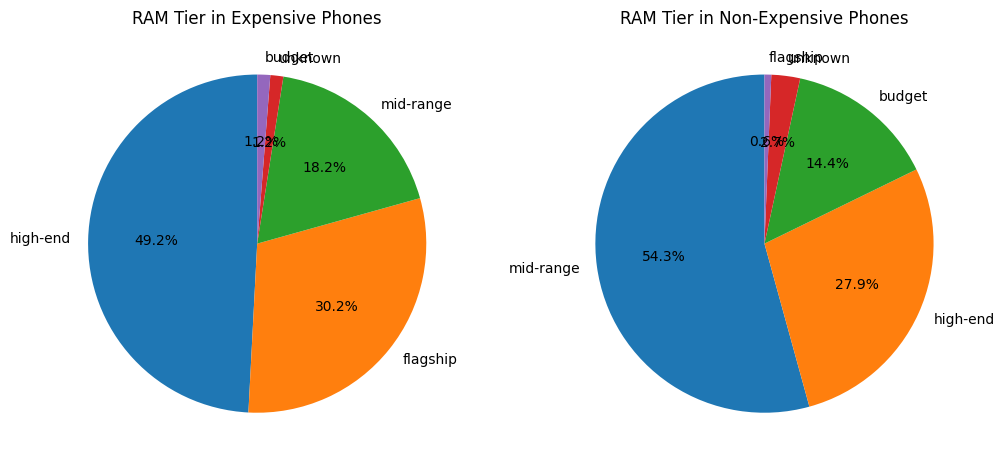

In [11]:
ram_tier_expensive = df_train[df_train['price'] == 'expensive']['RAM_Tier'].value_counts()
ram_tier_non_expensive = df_train[df_train['price'] == 'non-expensive']['RAM_Tier'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].pie(ram_tier_expensive, labels=ram_tier_expensive.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('RAM Tier in Expensive Phones')
axes[1].pie(ram_tier_non_expensive, labels=ram_tier_non_expensive.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('RAM Tier in Non-Expensive Phones')
plt.show()

# Expensive phones are dominated by High‑End and Flagship RAM tiers
# Non‑expensive phones cluster around Mid‑Range RAM

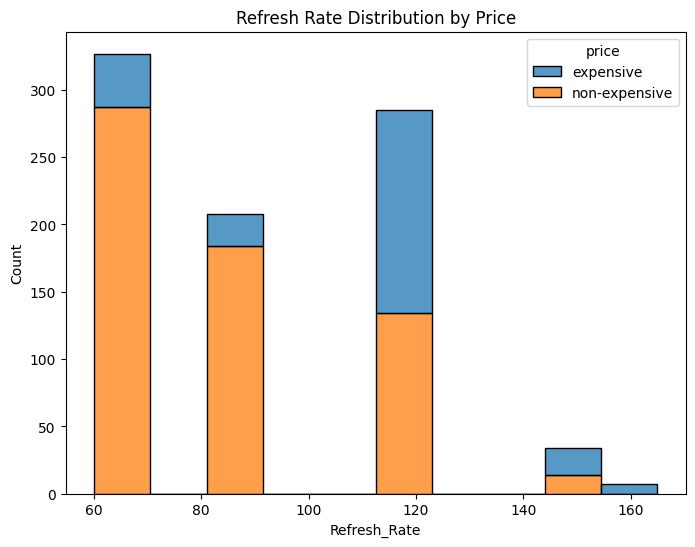

In [12]:
# Histogram: Refresh_Rate Distribution by Price
plt.figure(figsize=(8, 6))
sns.histplot(data=df_train, x='Refresh_Rate', hue='price', multiple='stack', bins=10)
plt.title('Refresh Rate Distribution by Price')
plt.show()
# Most non-expensive phones use a standard 60Hz refresh rate
# Expensive devices are dominant at higher refresh rates, especially 120Hz, and some even reach 145Hz or 160Hz

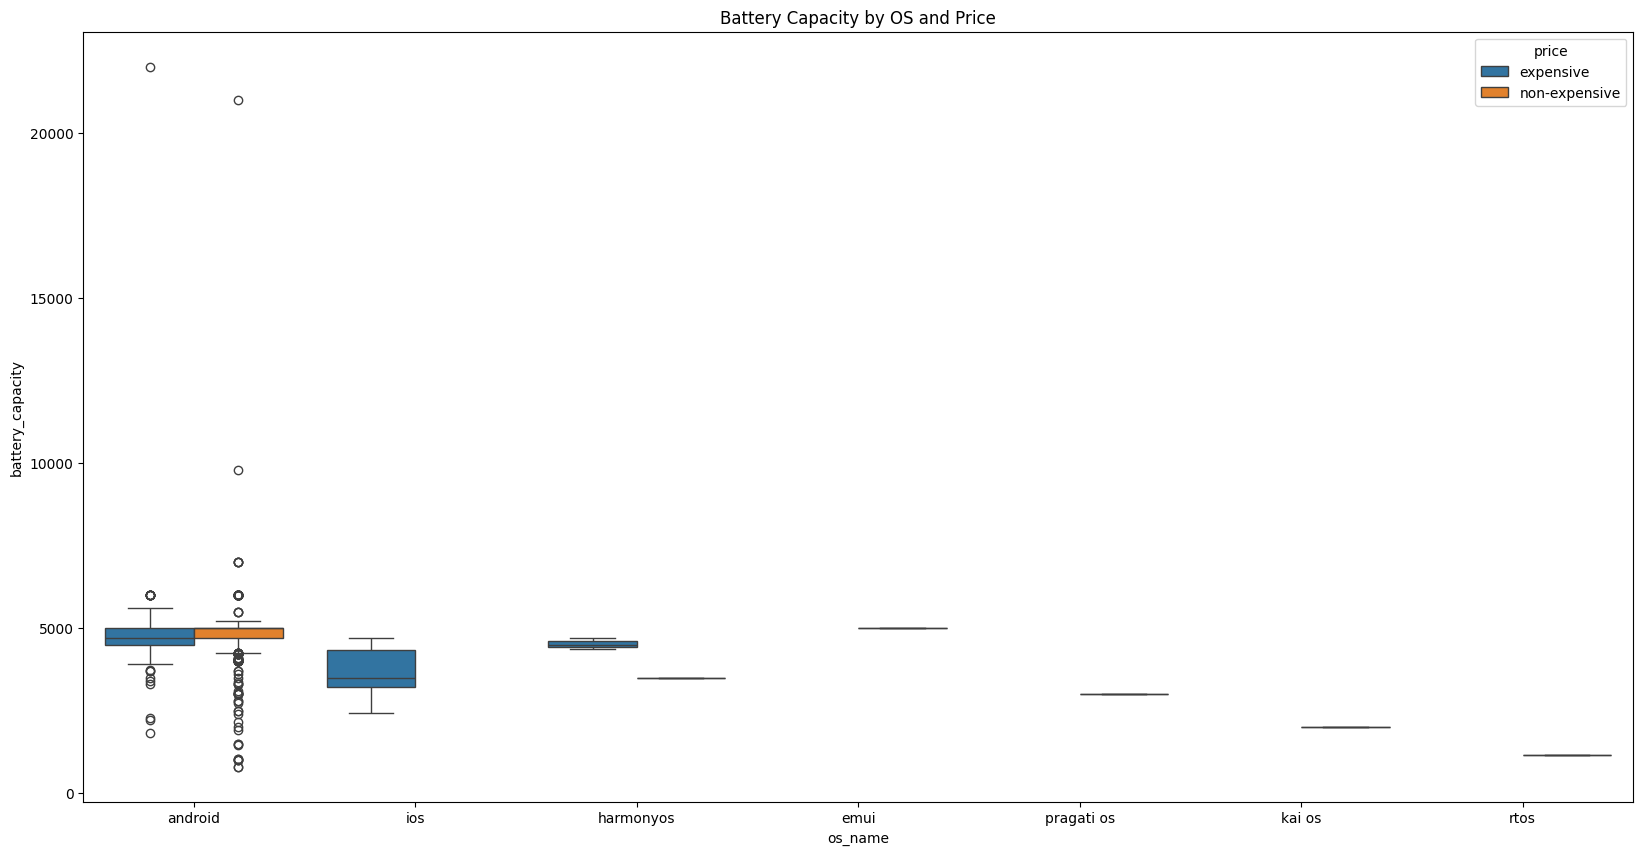

In [13]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_train, x='os_name', y='battery_capacity', hue='price')
plt.title('Battery Capacity by OS and Price')
plt.show()

# Feature Enginerring & Selection

In [14]:
def data_eng (df):
    df = df.copy()

    # Feature Engineering 
    # Create combined scores for performance and camera quality
    df['performance_score'] = df['Core_Count'] * df['Clock_Speed_GHz'] * (df['RAM_Size_GB'] / 4)
    df['camera_quality_score'] = (df['primary_rear_camera_mp'] * 0.7 + df['primary_front_camera_mp'] * 0.3)


    # --- Outlier/Skewness Treatment ---
    # List columns that need transformation
    outliers_col = ['rating', 'Processor_Series', 'Core_Count', 'Clock_Speed_GHz',
                    'RAM_Size_GB', 'Storage_Size_GB','fast_charging_power',
                    'Screen_Size', 'Resolution_Width', 'Resolution_Height', 'Refresh_Rate',
                    'primary_rear_camera_mp', 'primary_front_camera_mp', 'num_front_cameras', 'memory_card_size_GB']


    # Apply log transformation (np.log1p) to reduce skewness in numerical features
    outliers_col_clean = [col.strip() for col in outliers_col]
    for c in outliers_col_clean:
        df[c] = np.log1p(df[c])

    # --- Encoding ---
    # Define mapping for binary (Yes/No) features
    bmap = {'yes':1, 'no':0 , 'expensive': 1, 'non-expensive': 0}
    binary_columns = ['price', '5G', 'NFC']
    for col in binary_columns:
        df[col] = df[col].apply(lambda x: bmap[x])

    # Define the order for ordinal features (tiers)
    tiers_order = [
        ['unknown', 'budget', 'low-end', 'mid-range', 'high-end', 'flagship'],
        ['unknown', 'budget', 'low-end', 'mid-range', 'high-end', 'flagship']
    ]
    
    # Encode ordinal columns (Performance_Tier, RAM_Tier) based on their defined order
    oe = OrdinalEncoder(categories=tiers_order)
    df[['Performance_Tier', 'RAM_Tier']] = oe.fit_transform(df[['Performance_Tier', 'RAM_Tier']])

    joblib.dump(oe, 'oe.pkl')

    return df

In [15]:
df_train = data_eng(df_train)
df_test = data_eng(df_test)
df_train = replace_to_other(df_train,10)
df_test = replace_to_other(df_test,10)

In [16]:
# arget Encoding
# Initialize the Target Encoder for the 'brand' column
te = TargetEncoder(cols=['brand'], min_samples_leaf=20, smoothing=10)
df_train['brand'] = te.fit_transform(df_train['brand'], df_train['price'])
df_test['brand'] = te.transform(df_test['brand'])

# One-Hot Encoding 
# List of categorical columns for One-Hot Encoding
one_hot_cols = ['Processor_Brand', 'Notch_Type', 'os_name']
ohn = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the training data
encoded_train = ohn.fit_transform(df_train[one_hot_cols])
encoded_train_cols = ohn.get_feature_names_out(one_hot_cols)
encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_train_cols)


# Transform the test data using the fitted encoder
encoded_test = ohn.transform(df_test[one_hot_cols])
encoded_test_cols = ohn.get_feature_names_out(one_hot_cols)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_test_cols)


# Merging Encoded Features
# Merge the new One-Hot columns back into the training dataframe and drop originals
df_train.reset_index(drop=True, inplace=True)
df_train = pd.concat([df_train, encoded_train_df], axis=1)
df_train.drop(columns=one_hot_cols, inplace=True)

# Merge the new One-Hot columns back into the test dataframe and drop originals
df_test.reset_index(drop=True, inplace=True)
df_test = pd.concat([df_test, encoded_test_df], axis=1)
df_test.drop(columns=one_hot_cols, inplace=True)



In [17]:
joblib.dump(ohn, 'ohn.pkl')
joblib.dump(te, 'te.pkl')

['te.pkl']

In [18]:
print(df_train.columns.tolist())

['price', 'rating', 'Dual_Sim', '4G', '5G', 'Vo5G', 'NFC', 'IR_Blaster', 'Processor_Series', 'Core_Count', 'Clock_Speed_GHz', 'Performance_Tier', 'RAM_Size_GB', 'Storage_Size_GB', 'RAM_Tier', 'battery_capacity', 'fast_charging_power', 'Screen_Size', 'Resolution_Width', 'Resolution_Height', 'Refresh_Rate', 'primary_rear_camera_mp', 'num_rear_cameras', 'primary_front_camera_mp', 'num_front_cameras', 'memory_card_support', 'os_version', 'brand', 'memory_card_size_GB', 'performance_score', 'camera_quality_score', 'Processor_Brand_bionic', 'Processor_Brand_dimensity', 'Processor_Brand_exynos', 'Processor_Brand_helio', 'Processor_Brand_other', 'Processor_Brand_snapdragon', 'Processor_Brand_unisoc', 'Notch_Type_no notch', 'Notch_Type_punch hole', 'Notch_Type_small notch', 'Notch_Type_unknown', 'Notch_Type_water drop notch', 'os_name_android', 'os_name_ios']


In [19]:
selected_features = [
    'price','Core_Count','RAM_Size_GB','primary_rear_camera_mp' ,
    'primary_front_camera_mp','Processor_Series', 'performance_score',
    'Clock_Speed_GHz','Resolution_Height','camera_quality_score', 'NFC', 
    'Resolution_Width', 'Storage_Size_GB', 'RAM_Size_GB', 'rating', 'primary_front_camera_mp', 
    'fast_charging_power', 'Screen_Size', 'RAM_Tier', 'brand', 'Notch_Type_water drop notch', 
    'Processor_Brand_helio', 'primary_rear_camera_mp', 'Refresh_Rate', '5G']


df_train_final = df_train[selected_features].copy()
df_test_final = df_test[selected_features].copy()

X_train = df_train_final.drop('price', axis=1)
y_train = df_train_final['price']

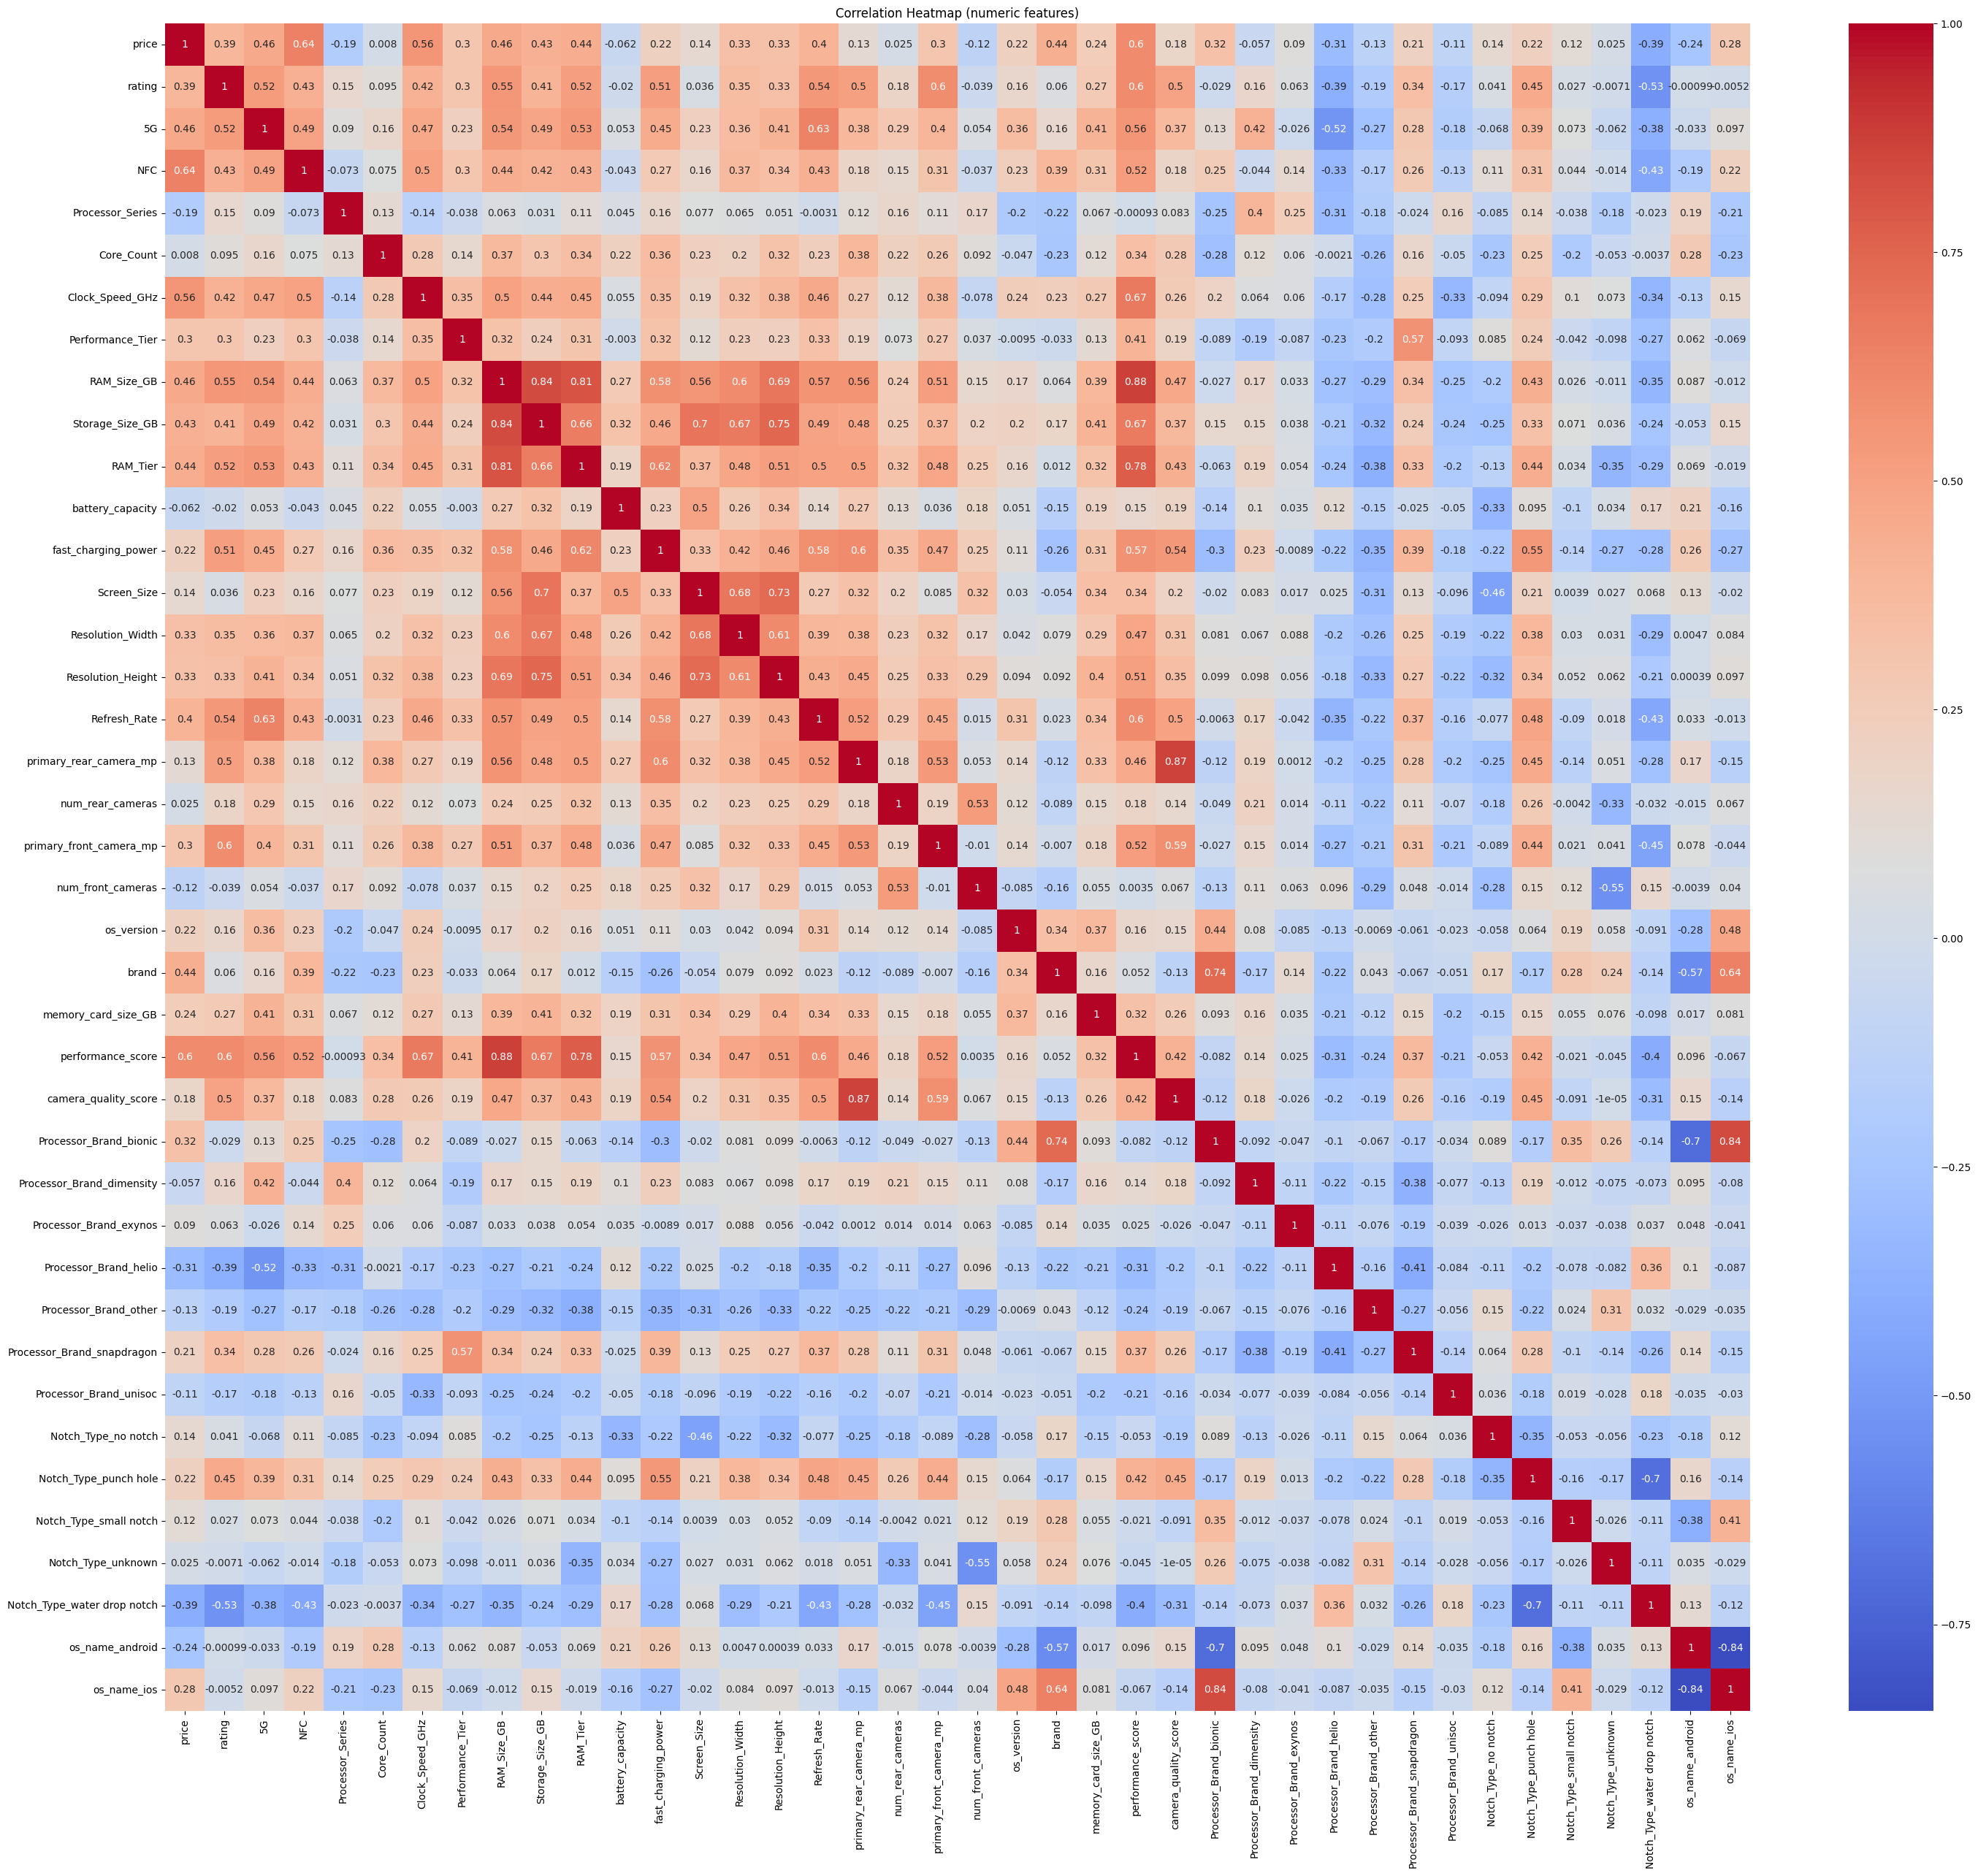

In [20]:
plt.figure(figsize=(35,30))
numeric_corr = df_train.select_dtypes(include='number').corr()
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (numeric features)')
plt.show()

Processor_Series           0.355378
performance_score          0.308613
Resolution_Height          0.220079
primary_front_camera_mp    0.212893
Clock_Speed_GHz            0.200582
NFC                        0.199500
camera_quality_score       0.193002
Resolution_Width           0.187521
RAM_Size_GB                0.179173
Storage_Size_GB            0.177798
primary_front_camera_mp    0.175708
RAM_Tier                   0.175142
RAM_Size_GB                0.169611
rating                     0.153356
fast_charging_power        0.152556
Screen_Size                0.138066
5G                         0.125354
Refresh_Rate               0.113376
brand                      0.112212
primary_rear_camera_mp     0.085300
dtype: float64


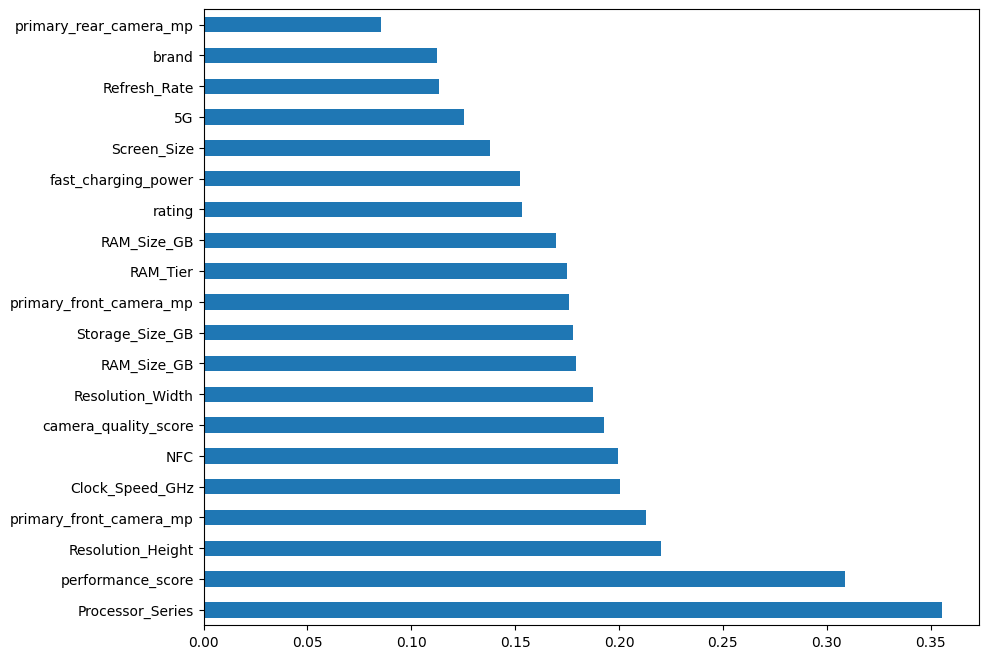

In [21]:
# Calculate Mutual Information (MI) between each feature and the target variable
mi = mutual_info_regression(X_train, y_train)

# Convert the MI scores into a pandas Series and index it by feature names
mi_series = pd.Series(mi, index=X_train.columns)

# Sort the features by their MI score in descending order
mi_series = mi_series.sort_values(ascending=False)

# Print the top 20 features with the highest MI scores
print(mi_series.head(20))

# Visualize the top 20 MI scores using a horizontal bar chart
plt.figure(figsize=(10,8))
mi_series.head(20).plot(kind='barh')
plt.show()

In [22]:
X_test = df_test_final.drop('price', axis=1)
y_test = df_test_final['price']

print(f"Features selected: {X_train.shape[1]}")
print(f"Train Shape: {X_train.shape}")
print(f"Test Shape:  {X_test.shape}")

Features selected: 24
Train Shape: (861, 24)
Test Shape:  (153, 24)


# Modeling

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
    "svm": SVC(probability=True),
    "xgboost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "knn": KNeighborsClassifier()
}

parameters = {
    "decision_tree": {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': [None, 'balanced']
    },
    "random_forest": {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'class_weight': [None, 'balanced']
    },
    "svm": {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly'],
        'degree': [2, 3],
        'class_weight': [None, 'balanced']
    },
    "xgboost": {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'scale_pos_weight': [1]
    },
    "knn": {
        'n_neighbors': [3, 5, 7, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2]
    }
}


In [24]:
def run_grid_search(models, parameters, X_train, y_train, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        print(f"\nRunning GridSearchCV for {model_name}...")

        grid_search = GridSearchCV(model, parameters[model_name], cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

        grid_search.fit(X_train, y_train)
        results[model_name] = grid_search

        print(f"Best parameters for {model_name}: {grid_search.best_params_}")


        y_pred = grid_search.predict(X_test)

        print(f"--- Results for {model_name} ---")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("=" * 40)


run_grid_search(models, parameters, X_train, y_train, X_test, y_test)


Running GridSearchCV for decision_tree...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters for decision_tree: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
--- Results for decision_tree ---
Confusion Matrix:
[[104   6]
 [ 10  33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       110
           1       0.85      0.77      0.80        43

    accuracy                           0.90       153
   macro avg       0.88      0.86      0.87       153
weighted avg       0.89      0.90      0.89       153


Running GridSearchCV for random_forest...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters for random_forest: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
--- 

### Models -> 2 

DecisionTree

classification report
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       110
           1       0.82      0.86      0.84        43

    accuracy                           0.91       153
   macro avg       0.88      0.89      0.89       153
weighted avg       0.91      0.91      0.91       153



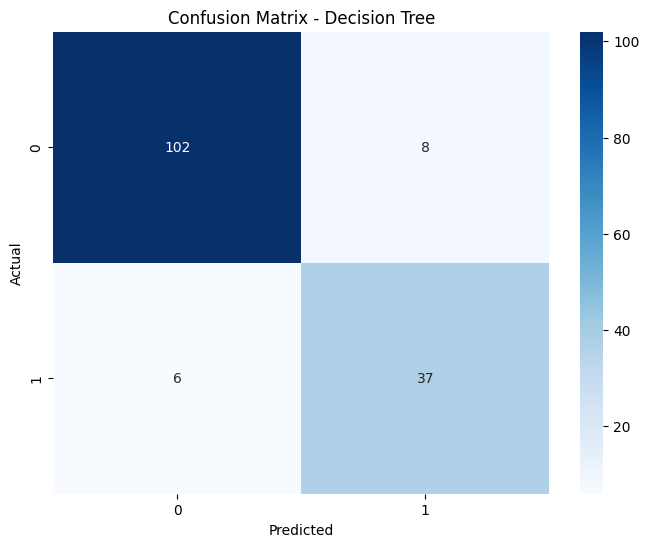

['DT.pkl']

In [25]:
DT=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=2)
DT.fit(X_train,y_train)
y_pred=DT.predict(X_test)
print("classification report")
print(classification_report(y_test,y_pred))
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()
joblib.dump(DT, 'DT.pkl')

SVM

classification report
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       110
           1       0.83      0.81      0.82        43

    accuracy                           0.90       153
   macro avg       0.88      0.88      0.88       153
weighted avg       0.90      0.90      0.90       153



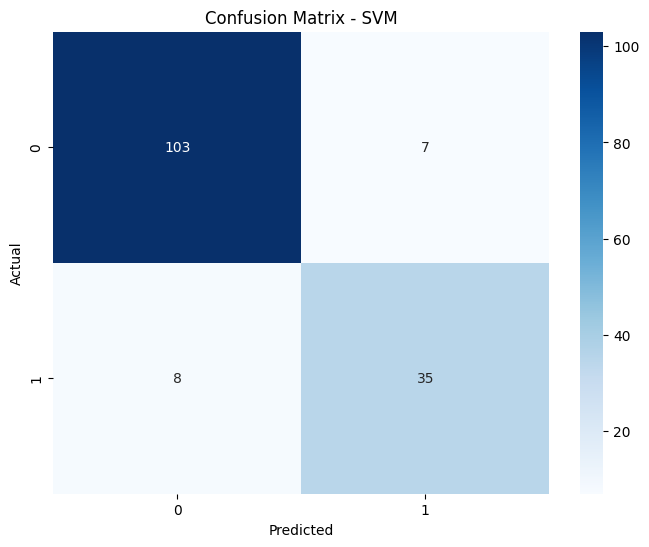

['SVM.pkl']

In [26]:
SVM=SVC(C=10, class_weight=None, degree=2, gamma='scale', kernel='rbf')   #with 30 features
SVM.fit(X_train,y_train)
y_pred=SVM.predict(X_test)
print("classification report")
print(classification_report(y_test,y_pred))
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

joblib.dump(SVM, 'SVM.pkl')

### Models -> 2 

Random Forest

classification report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       110
           1       0.83      0.91      0.87        43

    accuracy                           0.92       153
   macro avg       0.90      0.92      0.91       153
weighted avg       0.93      0.92      0.92       153



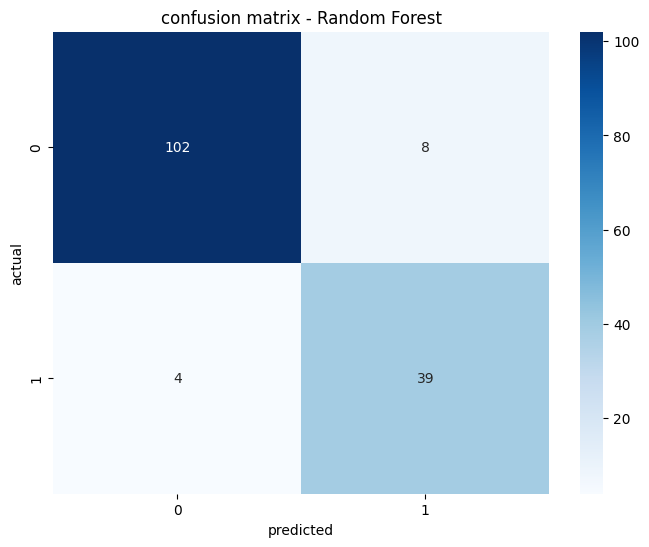

['RF.pkl']

In [27]:
rf =RandomForestClassifier(bootstrap=True, class_weight='balanced',
                            max_depth=20, max_features='sqrt', 
                            min_samples_leaf=1, min_samples_split=2, n_estimators=100)

rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print("classification report")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confusion matrix - Random Forest')
plt.show()

joblib.dump(rf, 'RF.pkl')

xgboost

classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       110
           1       0.91      0.93      0.92        43

    accuracy                           0.95       153
   macro avg       0.94      0.95      0.94       153
weighted avg       0.95      0.95      0.95       153



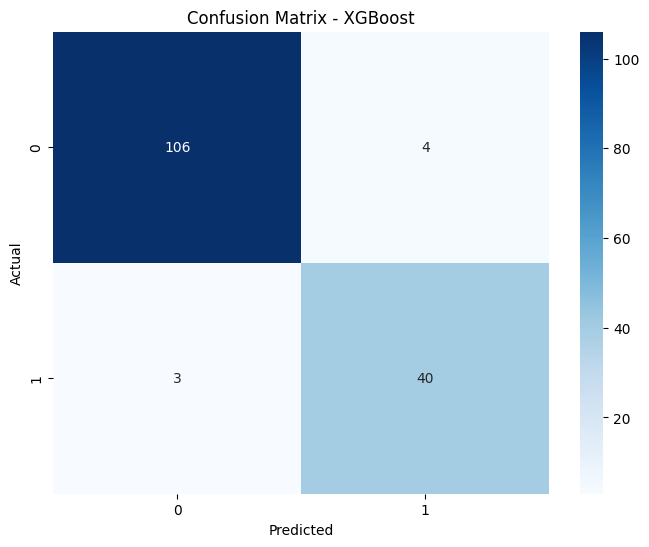

['XGB.pkl']

In [28]:
XGB = XGBClassifier(colsample_bytree=0.8, gamma=0, 
                    learning_rate=0.1, max_depth=3, 
                    n_estimators=200, scale_pos_weight=1, 
                    subsample=0.7, use_label_encoder=False, eval_metric='logloss')

XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

print("classification report")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

joblib.dump(XGB, 'XGB.pkl')

### Models -> 1

classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       110
           1       0.91      0.93      0.92        43

    accuracy                           0.95       153
   macro avg       0.94      0.95      0.94       153
weighted avg       0.95      0.95      0.95       153



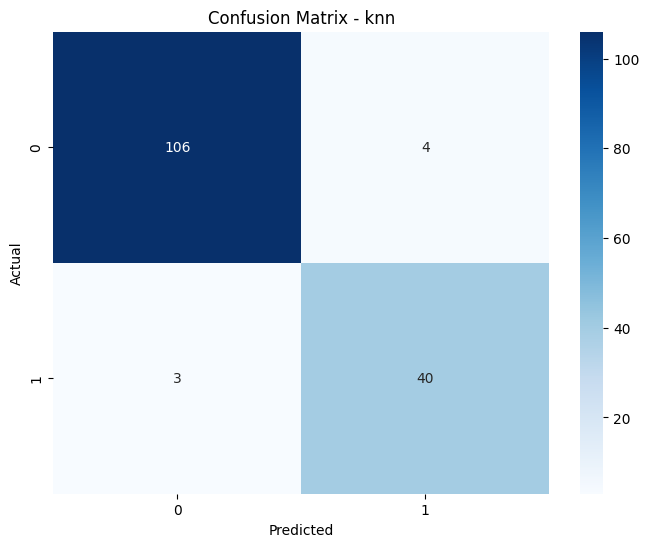

['knn.pkl']

In [29]:
knn = KNeighborsClassifier(n_neighbors = 7, p = 1, weights = 'distance', metric = 'manhattan')

knn.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

print("classification report")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - knn')
plt.show()

joblib.dump(knn, 'knn.pkl')